In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [4]:
emnist_train, emnist_test = tf.keras.datasets.mnist.load_data()

In [4]:
# emnist_train.client_ids[:10]

AttributeError: 'tuple' object has no attribute 'client_ids'

In [ ]:
# emnist_train.element_type_structure

In [5]:
# example_dataset = emnist_train.create_tf_dataset_for_client(
#     emnist_train.client_ids[0])

# example_element = next(iter(example_dataset))

# example_element['pixels'].numpy().shape

AttributeError: 'tuple' object has no attribute 'create_tf_dataset_for_client'

In [8]:
print('image shape with batch:', emnist_train[0].shape)

image shape with batch: (60000, 28, 28)


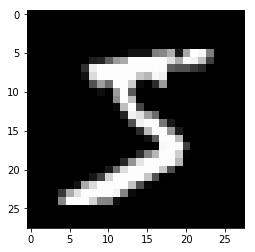

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(emnist_train[0][0], cmap='gray', aspect='equal')
plt.grid(False)
plt.show()

In [ ]:
# NUM_CLIENTS = 20
# NUM_EPOCHS = 5
# BATCH_SIZE = 64
# SHUFFLE_BUFFER = 100
# PREFETCH_BUFFER=10

# def preprocess(dataset):

#   def batch_format_fn(element):
#     """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
#     return collections.OrderedDict(
#         x=tf.reshape(element['pixels'],[-1, 28,28,1]),#tf.reshape(element['pixels'], [-1, 784]),
#         y=tf.reshape(element['label'], [-1, 1]))

#   return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
#       BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
NUM_EXAMPLES_PER_USER = 600
B = 10
BATCH_SIZE = NUM_EXAMPLES_PER_USER//B
EPOCHS = 20
NUMBER_OF_CLIENTS = 10

from tqdm import tqdm

def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in tqdm(range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE)):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([tf.reshape(source[0][i]/255.0, [28,28,1]) for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([tf.reshape(source[1][i], [1]) for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(emnist_train, d) for d in range(NUMBER_OF_CLIENTS)] * EPOCHS

federated_test_data = [get_data_for_digit(emnist_test, d) for d in range(NUMBER_OF_CLIENTS)]


 10%|█         | 1/10 [00:13<01:57, 13.07s/it]

In [6]:
preprocessed_example_dataset = preprocess(example_dataset)
preprocessed_example_dataset
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))
sample_batch['y'].shape


NameError: name 'preprocess' is not defined

In [ ]:
# def make_federated_data(client_data, client_ids):
#   return [
#       preprocess(client_data.create_tf_dataset_for_client(x))
#       for x in client_ids
#   ]

In [ ]:
#next(iter(preprocess(emnist_train.create_tf_dataset_for_client('f0000_14'))))
print("x shape:",federated_train_data[0][0]['x'].shape)
print("y shape:", federated_train_data[0][0]['y'].shape)


In [ ]:
type(emnist_train)

In [ ]:
#sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

#federated_train_data = make_federated_data(emnist_train, sample_clients)

# print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
# print('First dataset: {d}'.format(d=federated_train_data[0]))
# print('Second dataset: {d}'.format(d=federated_train_data[1]))

In [ ]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = (28,28,1)),
      tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu'),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu'),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation = 'relu'),
      tf.keras.layers.Dense(10),
      tf.keras.layers.Softmax(),
  ])

#       tf.keras.layers.Input(shape=(784,)),
#       tf.keras.layers.Dense(10, kernel_initializer='zeros'),
#       tf.keras.layers.Softmax(),

In [ ]:
input_spec = collections.OrderedDict(([('x',
              tf.TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)),
             ('y', tf.TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))]))
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=input_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
keras_model = create_keras_model()
keras_model.summary()

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [ ]:
str(iterative_process.initialize.type_signature)

In [ ]:
state = iterative_process.initialize()

In [ ]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

In [ ]:
NUM_ROUNDS = 200
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))